Coventry University
School of Computing, Engineering and Mathematics (CEM)
Faculty of Engineering, Environment and Computing (EEC)

# 6006CEM – Machine Learning
2021/2022

# Mihai Stavila
SID 8977658

# Introduction
"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed." 

This dataset is public available for research; the details are described in [Moro et al., 2014].

The classification goal is to predict whether the client will subscribe (yes/no) a term deposit (variable y).

# Setup & Basic Configuration

In [195]:
import numpy
import pandas
import psutil
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, \
    cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from statsmodels import api as sm_api
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot
import seaborn as sns

# make plot outputs appear and be stored within the notebook
%matplotlib inline

# initial plot settings
color_settings = {'yes':'#58ac6c', 'no':'#5074b4'}
pyplot.rc("font", size=14)
sns.set(style="whitegrid", color_codes=True)

pandas.options.mode.chained_assignment = None  # default='warn'

# Loading the data 
Load the dataset and display the columns, and first/last 5 rows

In [196]:
data = pandas.read_csv('bank.csv', sep=';', header=0)
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [197]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


# Data Analysis
Check the dataframe and relationships between the different attributes and uncover important predictors for the result variable by visualizing the data.

In [198]:
# Check for null values per column.
# Since there appear to be none in this dataset, there is no need to use pandas.DataFrame.dropna
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [199]:
data.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [200]:
# check if there are any duplicate rows, and if there are, analyse and decide whether it's an error or real data
print(data.shape)
print(data.drop_duplicates().shape)

(4521, 17)
(4521, 17)


In [201]:
# Display further information about the dataset, such as data types and NaN values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


data.info() shows that there are 10 categorical features and 7 numerical, and there are no null values in the dataset.

In [202]:
"""
"Descriptive statistics include those that summarize the central tendency, 
dispersion and shape of a dataset’s distribution, excluding NaN values."
"""
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521.000000,4521,4521,4521,4521,4521.000000,4521,4521,4521,4521.000000,4521,4521.000000,4521.000000,4521.000000,4521.000000,4521,4521
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,969,2797,2306,4445,NaN,2559,3830,2896,NaN,1398,NaN,NaN,NaN,NaN,3705,4000
mean,41.170095,NaN,NaN,NaN,NaN,1422.657819,NaN,NaN,NaN,15.915284,NaN,263.961292,2.793630,39.766645,0.542579,NaN,NaN
std,10.576211,NaN,NaN,NaN,NaN,3009.638142,NaN,NaN,NaN,8.247667,NaN,259.856633,3.109807,100.121124,1.693562,NaN,NaN
min,19.000000,NaN,NaN,NaN,NaN,-3313.000000,NaN,NaN,NaN,1.000000,NaN,4.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,69.000000,NaN,NaN,NaN,9.000000,NaN,104.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,444.000000,NaN,NaN,NaN,16.000000,NaN,185.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1480.000000,NaN,NaN,NaN,21.000000,NaN,329.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [203]:
count_subscribed = len(data[data.y =='yes'])
count_not_subscribed = len(data[data.y =='no'])
percentage_subscribed = count_subscribed / (count_not_subscribed + count_subscribed)
percentage_not_subscribed = count_not_subscribed / (count_not_subscribed + count_subscribed)
print(f'Subscribed:     {count_subscribed}  (% {percentage_subscribed * 100})')
print(f'Not subscribed: {count_not_subscribed} (% {percentage_not_subscribed * 100})')

Subscribed:     521  (% 11.523999115239992)
Not subscribed: 4000 (% 88.47600088476001)


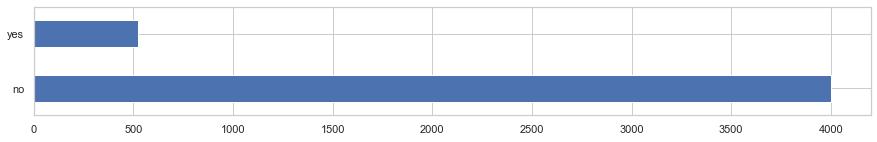

In [204]:
data.y.value_counts(normalize=False).plot(kind='barh', figsize=(15,2))
pyplot.show()

In [205]:
data.groupby(['y']).mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.998000,1403.211750,15.948750,226.347500,2.862250,36.006000,0.471250
yes,42.491363,1571.955854,15.658349,552.742802,2.266795,68.639155,1.090211


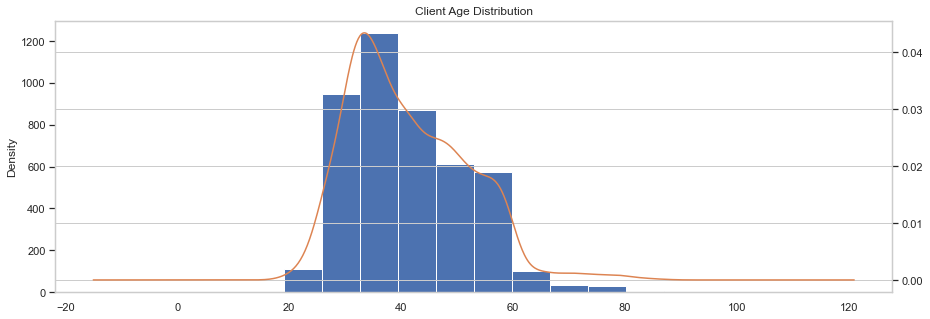

In [206]:
pyplot.figure(figsize=(15,5))
ax = data.age.plot.hist()
data.age.plot.kde(ax=ax, secondary_y=True)
pyplot.title('Client Age Distribution')
pyplot.xlabel('Age')
pyplot.show()

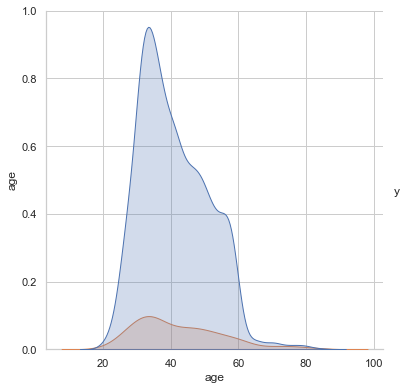

In [207]:
sns.pairplot(data=data, hue='y', vars=['age'], height=5.5)
pyplot.show()

## Job Type
job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

In [208]:
data.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.682008,1226.736402,16.324268,234.669456,2.631799,49.993724,0.644351
blue-collar,40.156448,1085.161734,15.482030,278.161734,2.846723,41.590909,0.493658
entrepreneur,42.011905,1645.125000,15.255952,285.476190,2.589286,32.273810,0.428571
housemaid,47.339286,2083.803571,15.294643,292.633929,2.500000,26.401786,0.357143
management,40.540764,1766.928793,16.254902,260.536636,2.973168,40.968008,0.549020
retired,61.869565,2319.191304,15.556522,285.656522,2.465217,35.073913,0.591304
self-employed,41.453552,1392.409836,16.180328,264.125683,3.278689,28.256831,0.590164
services,38.570743,1103.956835,15.515588,262.486811,2.822542,36.371703,0.443645
student,26.821429,1543.821429,16.392857,248.690476,2.392857,45.714286,0.964286


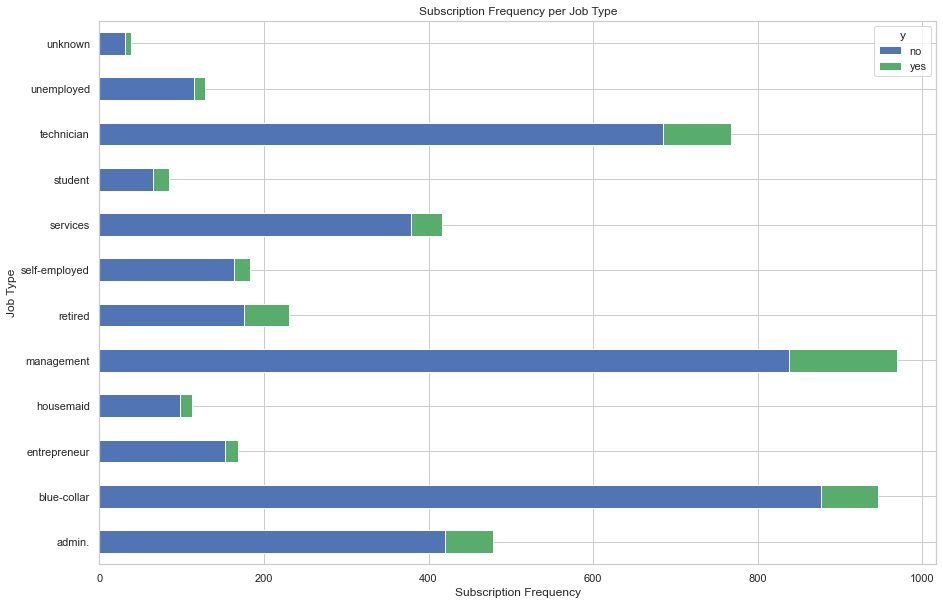

In [209]:
table = pandas.crosstab(data.job, data.y).plot(kind='barh', figsize=(15,10), stacked=True, color=color_settings)
pyplot.title('Subscription Frequency per Job Type')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Job Type')
pyplot.show()

## Education Level
education (categorical: 'primary','secondary','tertiary','unknown')

Note: education is a categorical (and not quantitative) variable due to inconsistent distinctions across categories and the lack of equal intervals.

In [210]:
data.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,46.833333,1411.544248,15.505900,261.709440,2.865782,35.069322,0.460177
secondary,40.062446,1196.814397,15.977884,269.863833,2.734172,40.934085,0.528621
tertiary,39.645926,1775.423704,16.009630,256.881481,2.901481,39.824444,0.612593
unknown,45.299465,1701.245989,15.946524,250.449198,2.486631,41.983957,0.508021


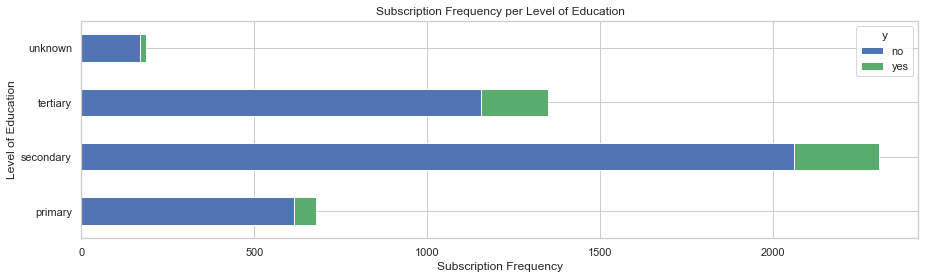

In [211]:
table=pandas.crosstab(data.education, data.y).plot(kind='barh', stacked=True, figsize=(15,4), color=color_settings, ylabel='test')
pyplot.title('Subscription Frequency per Level of Education')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Level of Education')
pyplot.show()

## Marital Status
marital : marital status (categorical: 'divorced','married','single'; note: 'divorced' means divorced or widowed)

In [212]:
data.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.475379,1122.390152,15.753788,279.232955,2.604167,38.827652,0.439394
married,43.454415,1463.195567,15.905971,256.528781,2.847336,38.466929,0.519128
single,33.927258,1460.414716,16.008361,274.601171,2.751672,43.220736,0.642977


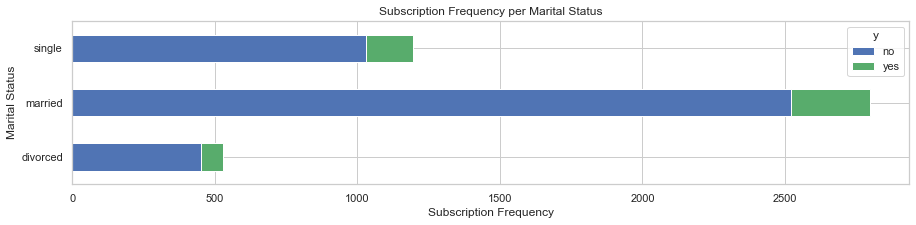

In [213]:
table=pandas.crosstab(data.marital, data.y).plot(kind='barh', stacked=True, figsize=(15,3), color=color_settings)
pyplot.title('Subscription Frequency per Marital Status')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Marital Status')
pyplot.show()

## Campaign Contacts
number of contacts performed during this campaign and for this client (numeric, includes last contact)

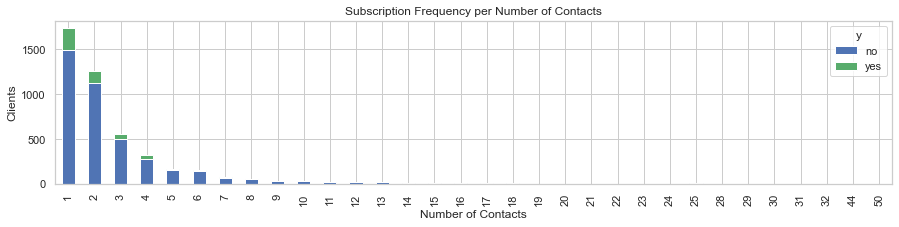

In [214]:
table=pandas.crosstab(data.campaign, data.y).plot(kind='bar', stacked=True, figsize=(15,3), color=color_settings)
pyplot.title('Subscription Frequency per Number of Contacts')
pyplot.xlabel('Number of Contacts')
pyplot.ylabel('Clients')
pyplot.show()

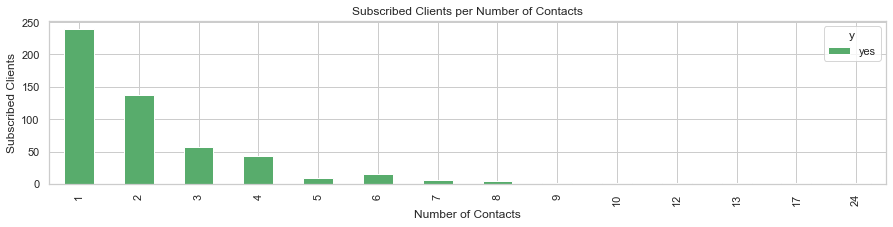

In [215]:
table=pandas.crosstab(data.campaign, data.y[data['y'] == 'yes']).plot(kind='bar', stacked=True, figsize=(15,3), color=color_settings)
pyplot.title('Subscribed Clients per Number of Contacts')
pyplot.ylabel('Subscribed Clients')
pyplot.xlabel('Number of Contacts')
pyplot.show()

## Contact Month
month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

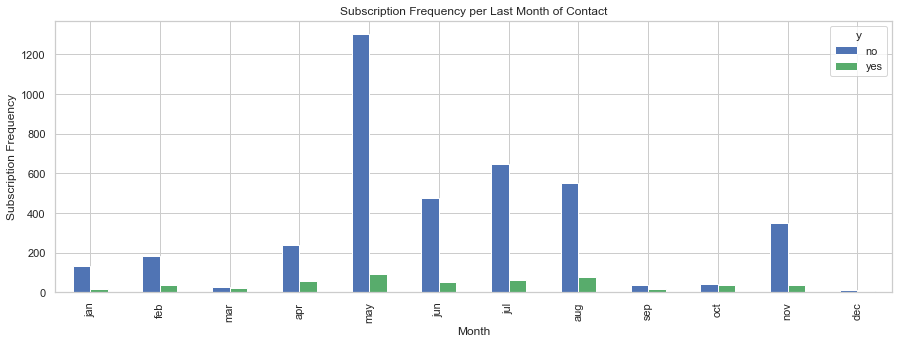

In [216]:
month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
data['month'] = pandas.Categorical(data['month'], categories=month, ordered=True)
data.sort_values(by='month', inplace=True)
pandas.crosstab(data.month, data.y).plot(kind='bar', figsize=(15,5), color=color_settings)
pyplot.title('Subscription Frequency per Last Month of Contact')
pyplot.xlabel('Month')
pyplot.ylabel('Subscription Frequency')
pyplot.show()

## Contact Day of Month
day : on which day of the month was the client contacted

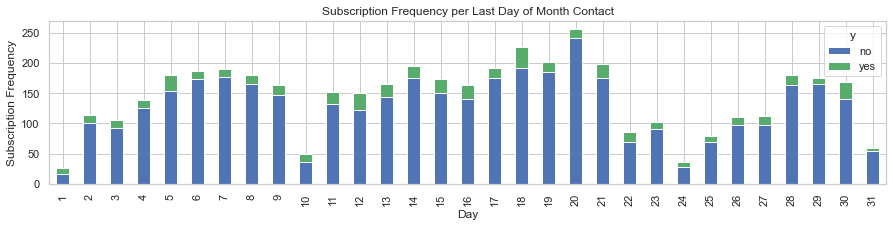

In [217]:
table=pandas.crosstab(data.day, data.y).plot(kind='bar', stacked=True, figsize=(15,3), color=color_settings)
pyplot.title('Subscription Frequency per Last Day of Month Contact')
pyplot.xlabel('Day')
pyplot.ylabel('Subscription Frequency')
pyplot.show()

## Previous Marketing Campaign Outcome
poutcome: outcome of the previous marketing campaign (categorical: 'failure','success','unknown','other')

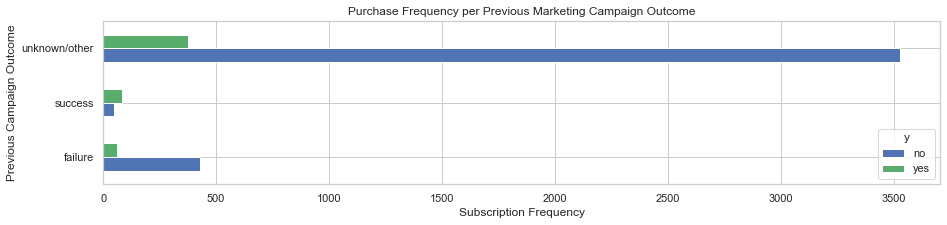

In [218]:
data['poutcome'] = numpy.where(data['poutcome'] == 'unknown', 'unknown/other', data['poutcome'])
data['poutcome'] = numpy.where(data['poutcome'] == 'other', 'unknown/other', data['poutcome'])
pandas.crosstab(data.poutcome, data.y).plot(kind='barh', figsize=(15,3), color=color_settings)
pyplot.title('Purchase Frequency per Previous Marketing Campaign Outcome')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Previous Campaign Outcome')
pyplot.show()

## Previous Contacts
previous: number of contacts performed before this campaign and for this client (numeric)

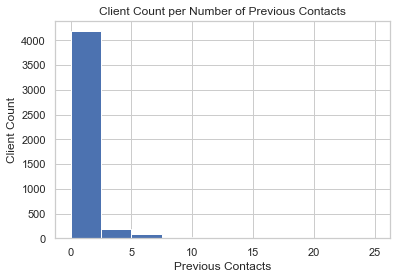

In [219]:
data.previous.hist()
pyplot.title('Client Count per Number of Previous Contacts')
pyplot.xlabel('Previous Contacts')
pyplot.ylabel('Client Count')
pyplot.show()

## Days after Previous Contact

pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted).

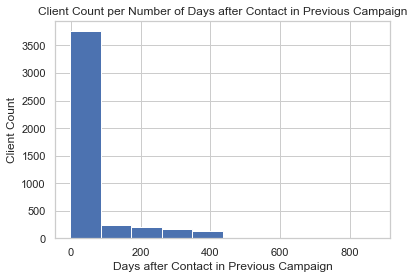

In [220]:
data.pdays.hist()
pyplot.title('Client Count per Number of Days after Contact in Previous Campaign')
pyplot.xlabel('Days after Contact in Previous Campaign')
pyplot.ylabel('Client Count')
pyplot.show()

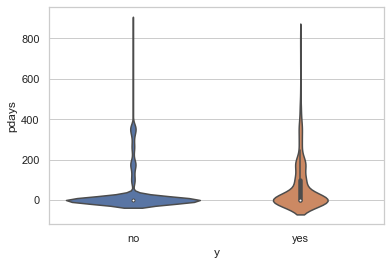

In [221]:
sns.violinplot(x='y', y='pdays', data=data)
pyplot.show()

## Client Personal Loan
loan: has personal loan? (categorical: 'no','yes','unknown')

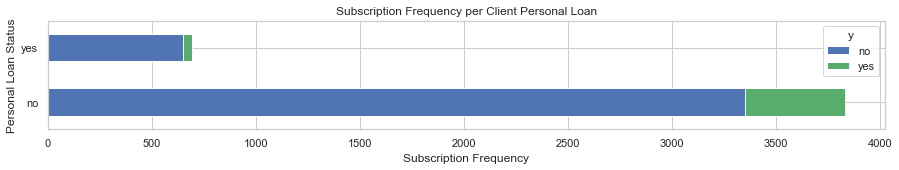

In [222]:
table=pandas.crosstab(data.loan, data.y).plot(kind='barh', stacked=True, figsize=(15,2), color=color_settings, ylabel='test')
pyplot.title('Subscription Frequency per Client Personal Loan')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Personal Loan Status')
pyplot.show()

## Client Housing Loan

housing: has housing loan? (categorical: 'no','yes','unknown')

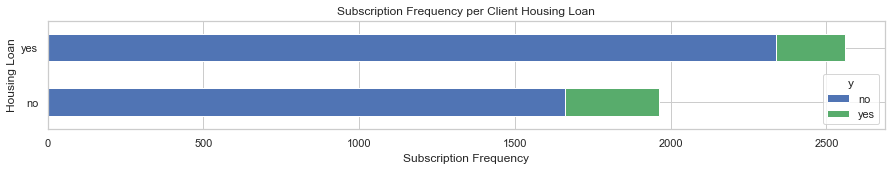

In [223]:
table=pandas.crosstab(data.housing, data.y).plot(kind='barh', stacked=True, figsize=(15,2), color=color_settings, ylabel='test')
pyplot.title('Subscription Frequency per Client Housing Loan')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Housing Loan')
pyplot.show()

## Contact Type
contact: contact communication type (categorical: 'cellular','telephone')


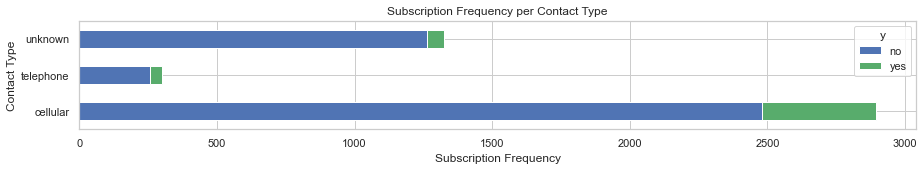

In [224]:
table=pandas.crosstab(data.contact, data.y).plot(kind='barh', stacked=True, figsize=(15,2), color=color_settings, ylabel='test')
pyplot.title('Subscription Frequency per Contact Type')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Contact Type')
pyplot.show()

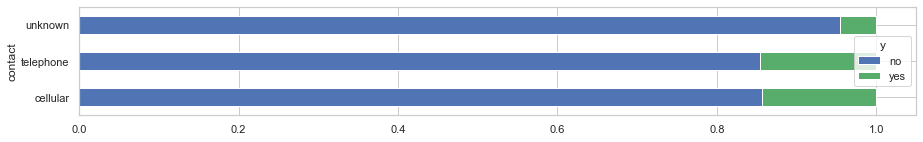

In [225]:
table=pandas.crosstab(data.contact, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, figsize=(15,2), color=color_settings, ylabel='test')
pyplot.show()

## Default (Credit)
default: has credit in default? (categorical: 'no','yes','unknown')

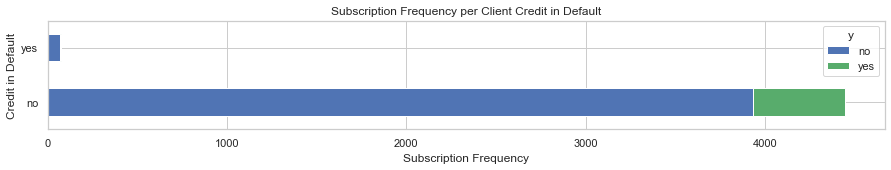

In [226]:
table=pandas.crosstab(data.default, data.y).plot(kind='barh', stacked=True, figsize=(15,2), color=color_settings, ylabel='test')
pyplot.title('Subscription Frequency per Client Credit in Default')
pyplot.xlabel('Subscription Frequency')
pyplot.ylabel('Credit in Default')
pyplot.show()

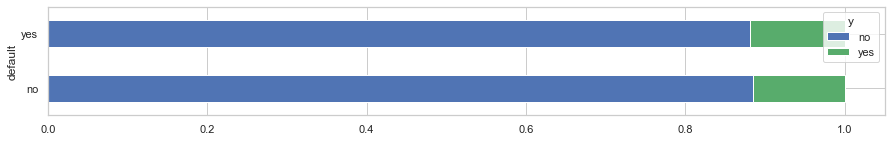

In [227]:
table=pandas.crosstab(data.default, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, figsize=(15,2), color=color_settings, ylabel='test')
pyplot.show()

## Contact Duration

duration: last contact duration, in seconds (numeric). 

Note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

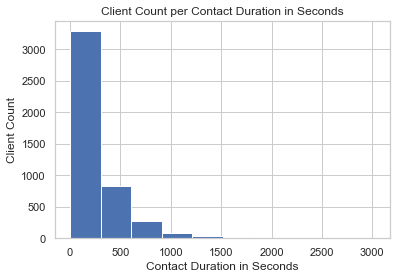

In [228]:
data.duration.hist()
pyplot.title('Client Count per Contact Duration in Seconds')
pyplot.xlabel('Contact Duration in Seconds')
pyplot.ylabel('Client Count')
pyplot.show()

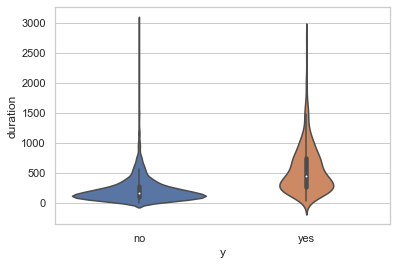

In [229]:
sns.violinplot(x='y', y='duration', data=data)
pyplot.show()

# Data Processing
Transform the data to make it more relevant and useable with sklearn.

In [230]:
data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1455,39,technician,married,tertiary,no,14,no,no,cellular,28,jan,114,2,-1,0,unknown/other,no
2502,32,admin.,married,secondary,no,0,no,no,cellular,30,jan,119,3,-1,0,unknown/other,no
1579,37,management,married,tertiary,no,539,no,no,cellular,18,jan,540,2,115,3,failure,no
3187,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown/other,yes
113,33,blue-collar,single,secondary,no,22,no,no,cellular,30,jan,76,2,207,1,failure,no
1633,59,blue-collar,married,primary,no,699,no,no,cellular,28,jan,98,1,154,6,failure,no
3908,36,technician,married,tertiary,no,167,yes,no,cellular,28,jan,57,1,-1,0,unknown/other,no
1634,42,unemployed,divorced,secondary,no,759,no,no,cellular,28,jan,97,1,169,3,failure,no
1569,43,unknown,single,unknown,no,181,no,no,telephone,28,jan,41,1,-1,0,unknown/other,no
2496,46,management,single,tertiary,no,593,yes,no,cellular,29,jan,190,3,-1,0,unknown/other,no


## Converting all yes/no columns to binary

In [231]:
# get columns that store a value of yes/no
yes_no_columns = ['y', 'default', 'loan', 'housing']

# replace yes/no with 0/1 and make sure the feature type is changed to integer
for column in yes_no_columns:
    data[column] = numpy.where(data[column] == 'yes', 1, data[column])
    data[column] = numpy.where(data[column] == 'no', 0, data[column])
    data[column] = data[column].astype(str).astype(int)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1455,39,technician,married,tertiary,0,14,0,0,cellular,28,jan,114,2,-1,0,unknown/other,0
2502,32,admin.,married,secondary,0,0,0,0,cellular,30,jan,119,3,-1,0,unknown/other,0
1579,37,management,married,tertiary,0,539,0,0,cellular,18,jan,540,2,115,3,failure,0
3187,63,retired,married,secondary,0,474,0,0,cellular,25,jan,423,1,-1,0,unknown/other,1
113,33,blue-collar,single,secondary,0,22,0,0,cellular,30,jan,76,2,207,1,failure,0


## One-Hot Encoding for the Categorical Variables
Convert categorical values (e.g. job, month, marital etc.) into Boolean dummy/indicator variables with no quantifiable relationships between them, to prepare the data for modeling.

In [232]:
# Return subset of all the object and categorical dtype columns in the dataframe
categorical_subset = data.select_dtypes(include=['object', 'category'])
categorical_subset

,job,marital,education,contact,month,poutcome
1455,technician,married,tertiary,cellular,jan,unknown/other
2502,admin.,married,secondary,cellular,jan,unknown/other
1579,management,married,tertiary,cellular,jan,failure
3187,retired,married,secondary,cellular,jan,unknown/other
113,blue-collar,single,secondary,cellular,jan,failure
...,...,...,...,...,...,...
1048,services,married,secondary,cellular,dec,success
1870,student,single,unknown,cellular,dec,unknown/other
1917,unemployed,married,primary,cellular,dec,unknown/other
3005,admin.,married,secondary,cellular,dec,success


In [233]:
categorical_columns = categorical_subset.columns.values.ravel()

for column in categorical_columns:
    # convert categorical variables into dummy indicator variables
    dummy_vars = pandas.get_dummies(data[column], prefix=column)
    temp = data.join(dummy_vars)
    data = temp
    
# drop one of the results for each categorical var to mitigate dummy variable trap (multicollinearity)
# manually instead of drop_first=True, as columns of less obvious significance can be removed instead
result_cols_to_drop = ['job_unknown', 'marital_divorced', 'education_unknown', 'contact_unknown', 'month_dec', 'poutcome_unknown/other']
data = data.drop(result_cols_to_drop, axis=1)

# remove categorical variables from the data
data = data.drop(categorical_columns, axis=1)

print(data.columns.values)
print(data.info())

['age' 'default' 'balance' 'housing' 'loan' 'day' 'duration' 'campaign'
 'pdays' 'previous' 'y' 'job_admin.' 'job_blue-collar' 'job_entrepreneur'
 'job_housemaid' 'job_management' 'job_retired' 'job_self-employed'
 'job_services' 'job_student' 'job_technician' 'job_unemployed'
 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'contact_cellular'
 'contact_telephone' 'month_jan' 'month_feb' 'month_mar' 'month_apr'
 'month_may' 'month_jun' 'month_jul' 'month_aug' 'month_sep' 'month_oct'
 'month_nov' 'poutcome_failure' 'poutcome_success']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 1455 to 3502
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  4521 non-null   int64
 1   default              4521 non-null   int32
 2   balance              4521 non-null   int64
 3   housing              4521 non-null   int32
 4   loan  

## Data Outliers
Get attributes with continuous values and plot them to identify potential outliers.

In [234]:
# Get a dictionary of max column values (e.g., {'age': 90, 'balance': 110000, ...})
columns_max_val = data.max().to_dict()
# Take only the columns with max values above 1 (continuous variables only)
continuous_columns = [key for key, val in columns_max_val.items() if val > 1]
continuous_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [235]:
continuous_subset = data[continuous_columns]
continuous_subset.describe(percentiles=[0.25,0.5,0.75,0.90,0.95,0.99])

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
90%,56.000000,3913.000000,28.000000,579.000000,6.000000,183.000000,2.000000
95%,59.000000,6102.000000,30.000000,763.000000,8.000000,317.000000,3.000000
99%,72.000000,14194.600000,31.000000,1259.000000,16.000000,370.000000,8.000000


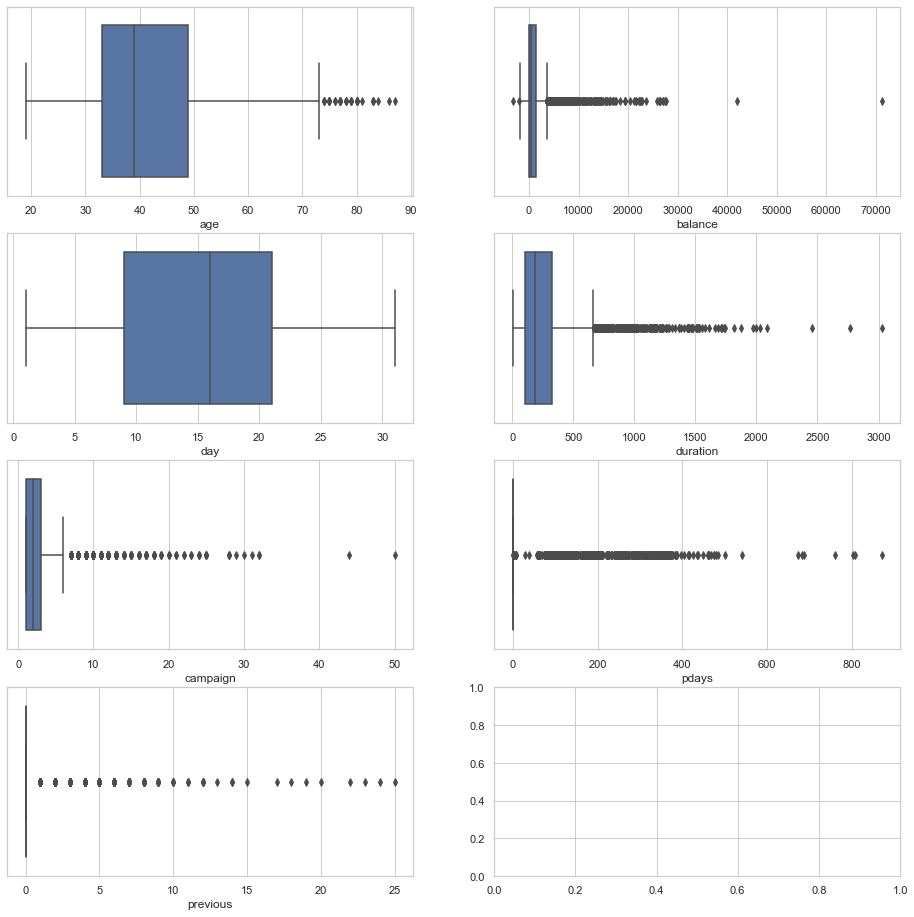

In [236]:
# calculate how many plots are needed
cont_count = len(continuous_columns)
fig, axes = pyplot.subplots(int(numpy.ceil(cont_count/2)), 2, figsize=(16,16))

# programmatically display the plots of outliers
r, c = 0, 0
for column in continuous_columns:
    sns.boxplot(x=data[column], ax=axes[r, c])
    if c == 1:
        r += 1
        c = 0
    else:
        c += 1

# check for data points located outside the whiskers of the box plot
pyplot.show()

## Data Correlation
Correlation coefficients of less than 0.3 are regarded weak, 0.3-0.7 are considered moderate and those above 0.7 are considered high. A color-encoded matrix of the dataframe's correlation of columns will be plotted and used to detect strong correlations between predictor features.

### Correlation between target and predictors

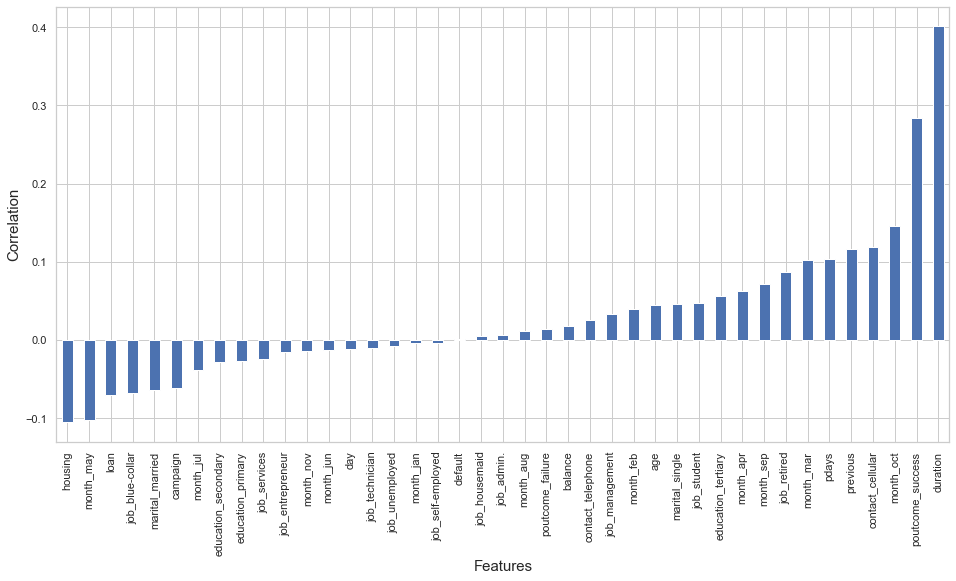

In [237]:
# Apply a function alongside the axis of the dataframe to get correlation to target variable for each predictor column/feature
target_correlation =  data.drop("y", axis=1).apply(lambda x: x.corr(data.y))
target_correlation = target_correlation.sort_values(ascending=True)
target_correlation.plot(kind='bar', figsize=(16,8))

pyplot.xlabel("Features", fontsize=15)
pyplot.ylabel("Correlation", fontsize=15)
pyplot.show()

The target/predictor correlation plot shows that contact duration has a great impact on client subscription. During analysis, it was shown that the longer the call duration, the higher the chance of the client subscribing.

Previous campaign outcome also highly affects the output: if a client has subscribed before, he is more likely to do so again.

Cellular contact is shown to have a high correlation due to the majority of contacts being of this type.

Other high-correlation predictors include housing, month_may & month_oct, previous contact count and days that passed since client was contacted from a previous campaign.



### Predictor Multicollinearity
Plot a color-encoded correlation matrix of all variables, then compute the variance inflation factor for each column, and begin the iterative process of removing multicollinear features, starting with the highest-correlated predictors with the largest VIF values.

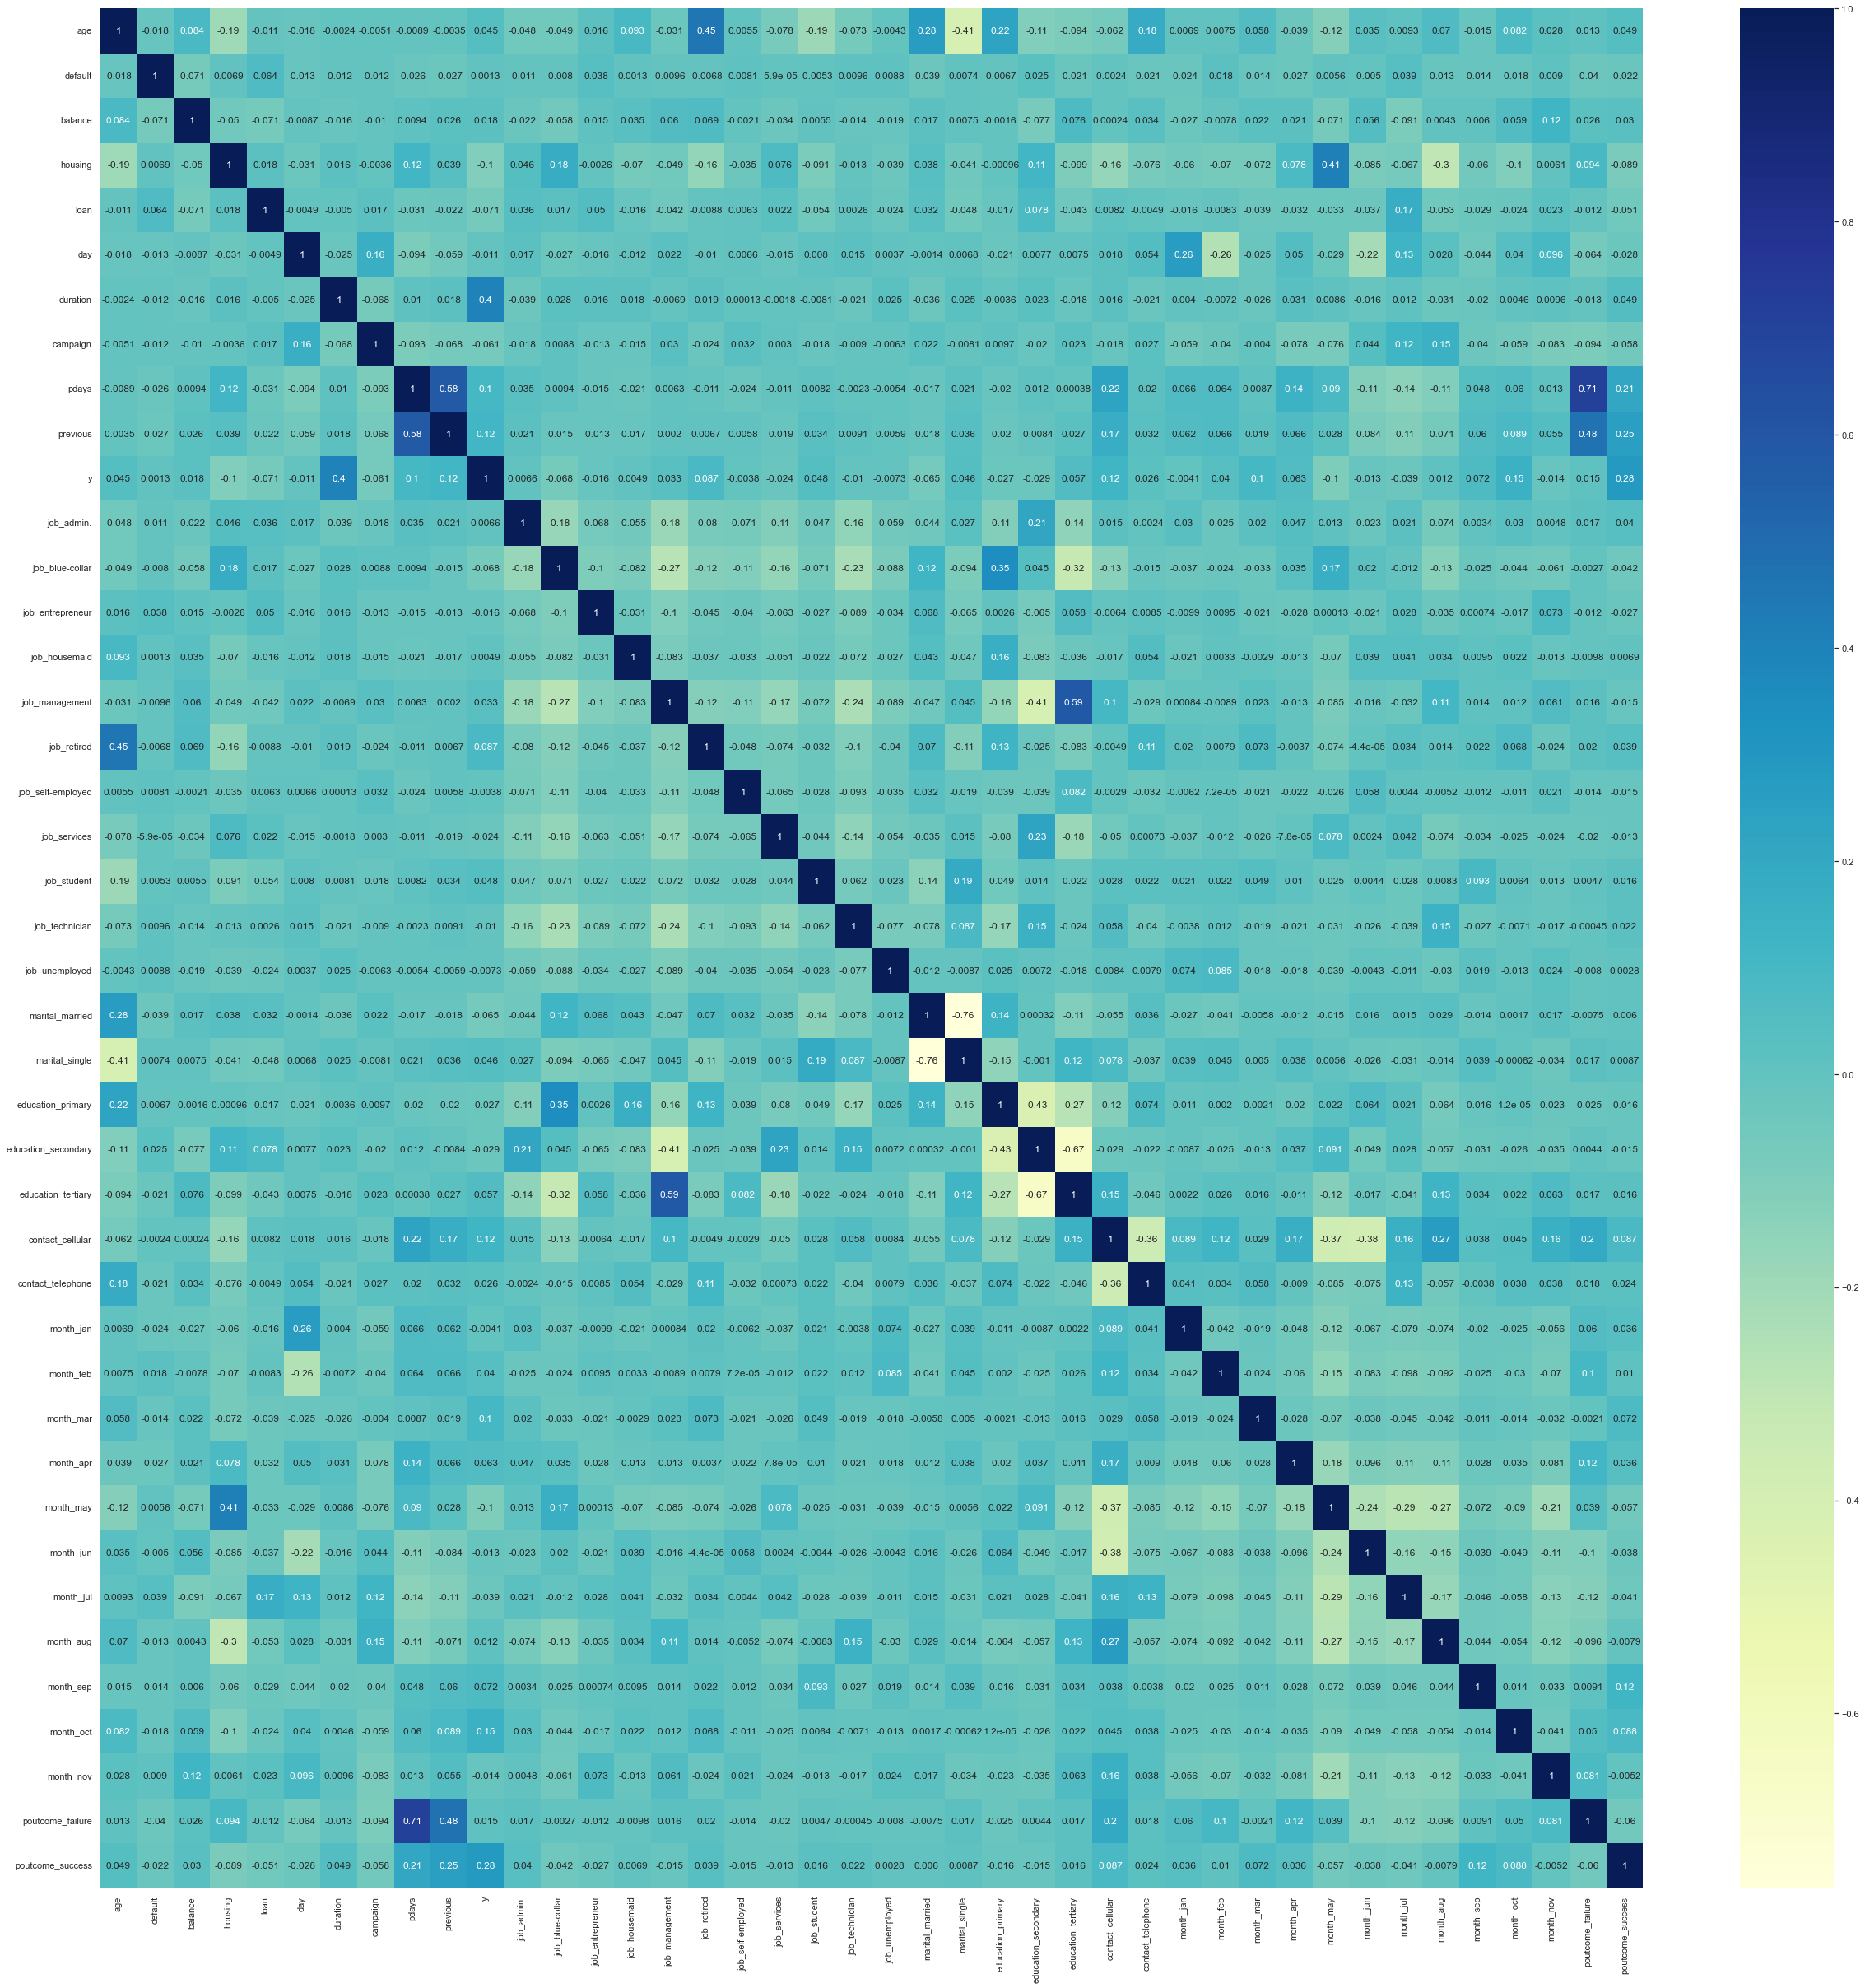

In [238]:
pyplot.figure(figsize=(data.shape[1], data.shape[1]))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")
pyplot.show()

Using the correlation matrix and VIF (Variance Inflation Factor) of the data, features with high correlation to other predictors have been identified.

In [239]:
def show_high_correlation():
    """ Display high correlations between features/columns """
    high_corr = {}
    columns_correlations = data.corr().to_dict()
    for column, correlations in columns_correlations.items():
        for col, corr in correlations.items():
            if (corr > 0.7 or corr < -0.7) and column != col:
                high_corr[column] = {}
                high_corr[column][col] = corr
    return high_corr

show_high_correlation()

{'pdays': {'poutcome_failure': 0.708380188954886},
 'marital_married': {'marital_single': -0.7639190978413278},
 'marital_single': {'marital_married': -0.7639190978413278},
 'poutcome_failure': {'pdays': 0.708380188954886}}

In [240]:
# Manually drop features of less importance to the outcome using the target/predictor correlation bar graph
data = data.drop(['poutcome_failure', 'marital_single'], axis=1)

In [241]:
show_high_correlation()

{}

In [242]:
# One recommendation is that if Variance Inflation Factor is greater than 5, then the explanatory variable given by exog_idx is 
# highly collinear with the other explanatory variables, and the parameter estimates will have 
# large standard errors because of this.
# Therefore, the cut-off point will be 5.0
vif_cutoff = 5.0
def high_vif_variables():
    """ Compute the VIF for all variables and return those with a VIF value greater than the cutoff point. """
    high_corr_col = {}
    for column in data.columns:
        i = data.columns.get_loc(column)
        vif = variance_inflation_factor(data, i)
        if vif > vif_cutoff:
            high_corr_col[column] = vif
    return high_corr_col

high_vif_variables()


{'age': 23.57843683671733,
 'day': 6.281804583717436,
 'job_admin.': 10.70105296794259,
 'job_blue-collar': 20.36195790042502,
 'job_management': 21.08803587911943,
 'job_retired': 6.0433508978583115,
 'job_services': 9.544765538797323,
 'job_technician': 16.552889808079666,
 'education_secondary': 14.01421737614326,
 'education_tertiary': 9.213240845665416,
 'contact_cellular': 7.421635630868919,
 'month_feb': 5.868683147960128,
 'month_apr': 7.6634534562891075,
 'month_may': 31.469719334637105,
 'month_jun': 12.154560721418365,
 'month_jul': 17.153480770324002,
 'month_aug': 15.402847112596989,
 'month_nov': 9.971433118430454}

In [243]:
# Remove high VIF variables starting with the largest, until there are no more variables with a VIF higher than the cutoff point.
# When dropping variables with a high VIF, the VIF value of other variables will be consequently lowered.
# Dropping the variable with the highest VIF on each iteration ensures that other variables are not dropped needlessly.

dropped_cols = {}
while high_vif_variables():
    high_vif = high_vif_variables()
    print(f'Variables with high VIF:\n{high_vif}')
    highest_vif_col = max(high_vif, key=high_vif.get)
    highest_vif_val = high_vif[highest_vif_col]
    data = data.drop([highest_vif_col], axis=1)
    print(f'Dropped "{highest_vif_col}" with VIF {highest_vif_val}', end='\n\n')
    dropped_cols[highest_vif_col] = highest_vif_val

print(f'Dropped all variables with a VIF greater than {vif_cutoff} from the dataset.')

print(f'List of dropped variables and their respective VIF value at time of removal:\n{dropped_cols}')


Variables with high VIF:
{'age': 23.57843683671733, 'day': 6.281804583717436, 'job_admin.': 10.70105296794259, 'job_blue-collar': 20.36195790042502, 'job_management': 21.08803587911943, 'job_retired': 6.0433508978583115, 'job_services': 9.544765538797323, 'job_technician': 16.552889808079666, 'education_secondary': 14.01421737614326, 'education_tertiary': 9.213240845665416, 'contact_cellular': 7.421635630868919, 'month_feb': 5.868683147960128, 'month_apr': 7.6634534562891075, 'month_may': 31.469719334637105, 'month_jun': 12.154560721418365, 'month_jul': 17.153480770324002, 'month_aug': 15.402847112596989, 'month_nov': 9.971433118430454}
Dropped "month_may" with VIF 31.469719334637105

Variables with high VIF:
{'age': 21.174652580566825, 'day': 6.184267950976942, 'job_admin.': 6.053988766792871, 'job_blue-collar': 10.84276142310852, 'job_management': 12.050875882733342, 'job_services': 5.351870096016449, 'job_technician': 9.152010979670438, 'education_secondary': 13.40730168811696, 'edu

### Re-checking the correlation matrix
After removing the high-correlation/high-VIF variables, the overall dataset predictor collinearity has been visibly reduced, and therefore the statistical significance of independent variables has been improved.

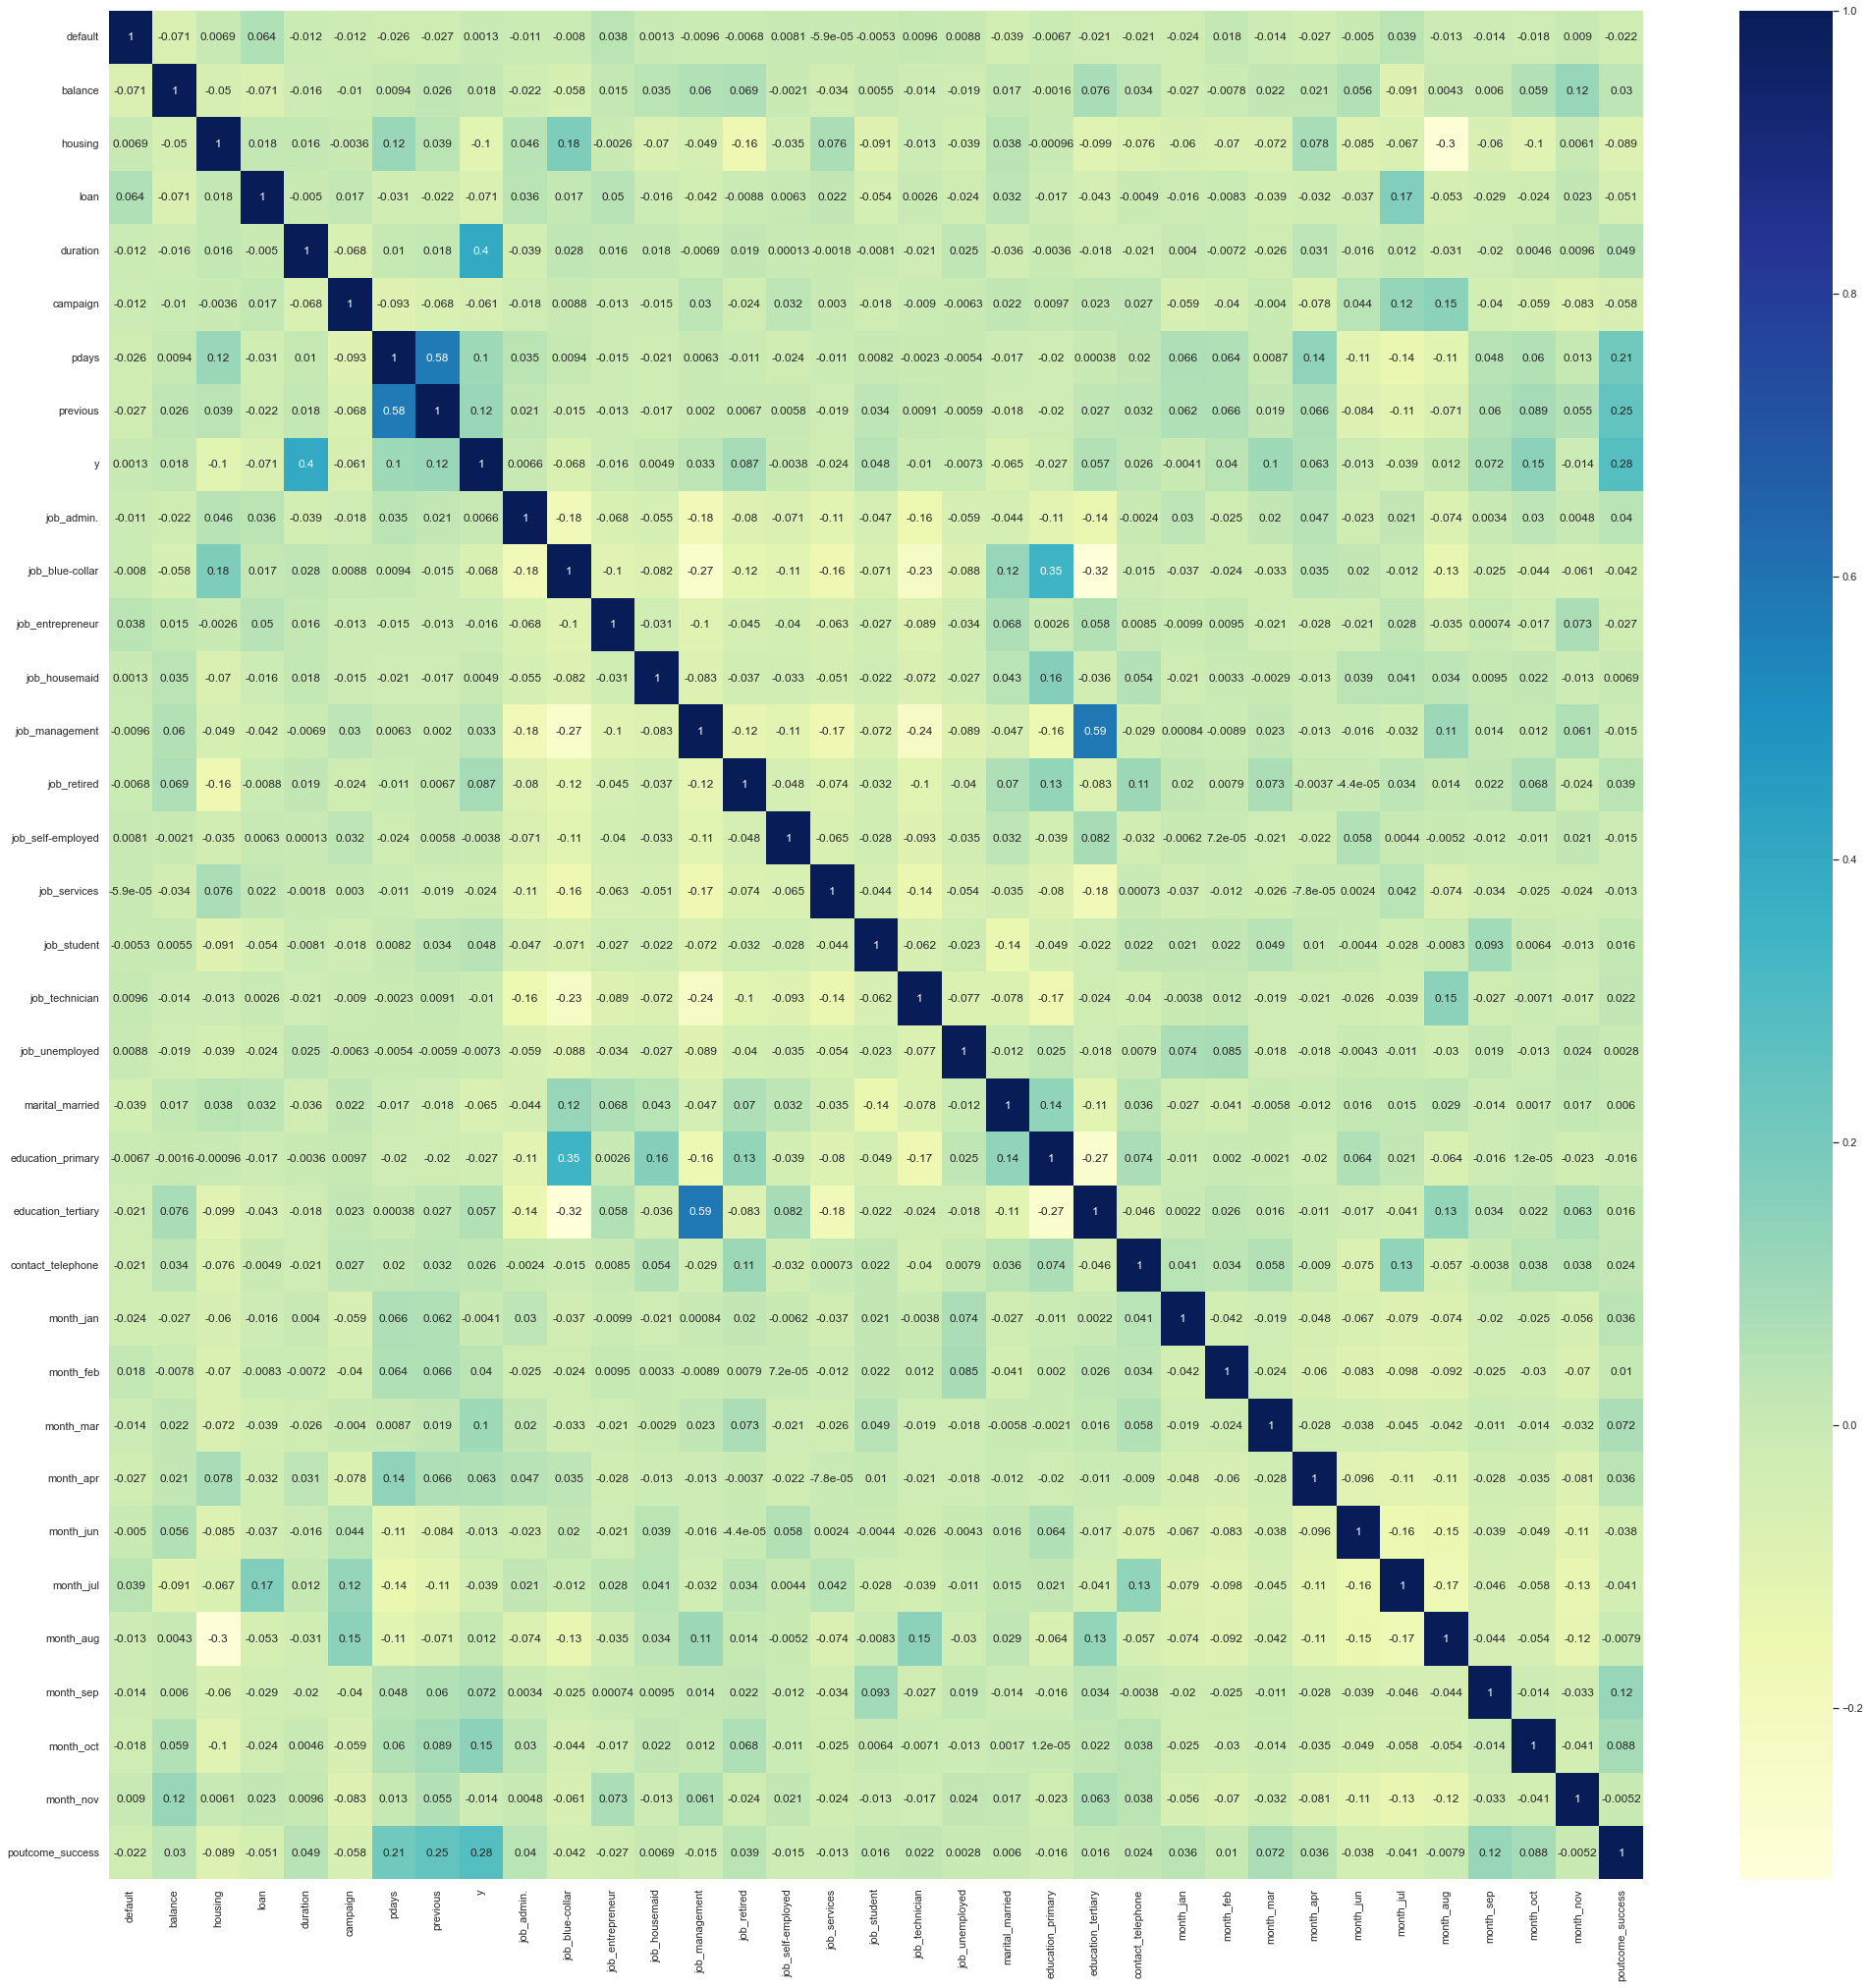

In [244]:
pyplot.figure(figsize=(data.shape[1], data.shape[1]))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")
pyplot.show()

## Feature Scaling
Scale all values in the [0, 1] range and preserve the dataset shape with MinMaxScaler.

In [245]:
data.head()

,default,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,...,month_feb,month_mar,month_apr,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,poutcome_success
1455,0,14,0,0,114,2,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2502,0,0,0,0,119,3,-1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1579,0,539,0,0,540,2,115,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3187,0,474,0,0,423,1,-1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
113,0,22,0,0,76,2,207,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
# Only scale columns with values larger than one.
columns_to_scale = [col for col in data.columns if numpy.issubdtype(data[col].max(), numpy.integer) 
                    and data[col].max() > 1]

mm_scaler = preprocessing.MinMaxScaler()

# Scale the training and test data in the same way
data[columns_to_scale] = mm_scaler.fit_transform(data[columns_to_scale])

data.head()

,default,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,...,month_feb,month_mar,month_apr,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,poutcome_success
1455,0,0.044657,0,0,0.036412,0.020408,0.000000,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
2502,0,0.044469,0,0,0.038067,0.040816,0.000000,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0
1579,0,0.051704,0,0,0.177425,0.020408,0.133028,0.12,0,0,...,0,0,0,0,0,0,0,0,0,0
3187,0,0.050832,0,0,0.138696,0.000000,0.000000,0.00,1,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0.044764,0,0,0.023833,0.020408,0.238532,0.04,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Splitting
Split the data into train set (80%) for model building and validation and test set (20%) for a final unbiased evaluation.

### Separating the predictor features and target variable

In [247]:
X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']

In [248]:
X

,default,balance,housing,loan,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,month_feb,month_mar,month_apr,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,poutcome_success
1455,0,0.044657,0,0,0.036412,0.020408,0.000000,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
2502,0,0.044469,0,0,0.038067,0.040816,0.000000,0.00,1,0,...,0,0,0,0,0,0,0,0,0,0
1579,0,0.051704,0,0,0.177425,0.020408,0.133028,0.12,0,0,...,0,0,0,0,0,0,0,0,0,0
3187,0,0.050832,0,0,0.138696,0.000000,0.000000,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0.044764,0,0,0.023833,0.020408,0.238532,0.04,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,0,0.062415,0,0,0.107911,0.020408,0.146789,0.12,0,0,...,0,0,0,0,0,0,0,0,0,1
1870,0,0.189273,0,0,0.032440,0.020408,0.241972,0.08,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,0,0.057623,1,0,0.115194,0.000000,0.000000,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
3005,0,0.094603,0,0,0.061569,0.000000,0.216743,0.36,1,0,...,0,0,0,0,0,0,0,0,0,1


In [249]:
y

,y
1455,0
2502,0
1579,0
3187,1
113,0
...,...
1048,1
1870,0
1917,1
3005,1


### Train Test Split
Split the data into train and test subsets.

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}')

X_train: 3616, X_test: 905


## Initial Model Performance
Display the confusion matrix and classification report to help analyze the models' performance (Logistic Regression & Random Forest Classification).

In [251]:
def display_model_performance():
    """
    Fit each classifier to the current training data and display the model's performance with default parameters
    using its confusion matrix and classification report.
    """
    model_logit = LogisticRegression(max_iter=10000)
    model_logit = model_logit.fit(X_train, y_train.values.ravel())
    print(model_logit.__class__.__name__)
    print(metrics.confusion_matrix(y_test, model_logit.predict(X_test)))
    print(metrics.classification_report(y_test, model_logit.predict(X_test)), end='\n\n')

    rforest_model = RandomForestClassifier()
    rforest_model = rforest_model.fit(X_train, y_train.values.ravel())
    print(rforest_model.__class__.__name__)
    print(metrics.confusion_matrix(y_test, rforest_model.predict(X_test)))
    print(metrics.classification_report(y_test, rforest_model.predict(X_test)))

display_model_performance()

LogisticRegression
[[795   6]
 [ 82  22]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       801
           1       0.79      0.21      0.33       104

    accuracy                           0.90       905
   macro avg       0.85      0.60      0.64       905
weighted avg       0.89      0.90      0.88       905


RandomForestClassifier
[[781  20]
 [ 75  29]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       801
           1       0.59      0.28      0.38       104

    accuracy                           0.90       905
   macro avg       0.75      0.63      0.66       905
weighted avg       0.88      0.90      0.88       905



### Cross-Validation Mean Score

In [252]:
# Preserve dataset class distribution with StratifiedKFold
# Fixed random state ensures the same shuffle and therefore same split each time the code is run
# Shuffle to get meaningful cross-validation result as the data ordering is not arbitrary
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

def display_model_performance_mean():
    for estimator in [LogisticRegression(max_iter=1000), RandomForestClassifier()]:
        print(estimator.__class__.__name__)
        for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
            score = cross_val_score(estimator=estimator, X=X_train, y=y_train.values.ravel(), cv=stratified_kfold, scoring=metric)
            print(f'Mean {metric}: {numpy.mean(score)}')
        print('\n')

display_model_performance_mean()

LogisticRegression
Mean accuracy: 0.894357294807242
Mean precision_macro: 0.7616375560559563
Mean recall_macro: 0.5982097858162303
Mean f1_macro: 0.6295096008852358


RandomForestClassifier
Mean accuracy: 0.8974013253546778
Mean precision_macro: 0.7628622957885177
Mean recall_macro: 0.6188160216395603
Mean f1_macro: 0.6474450359214822




## Further Processing

### Feature Selection - Recursive Feature Elimination
Use the RFE algorithm to select the most relevant attributes to the target variable and remove those with low significance by iteratively building a model and pruning the least important features each time, until all the dataset's features have been checked. On the trimmed set, this approach is continued recursively until the required number of features to choose is attained, hence the name "Recursive Feature Elimination". 

Note: According to the SMOTE paper, feature selection should be performed before over-sampling.

In [253]:
# initialize and fit the train set to RFE with Logit estimator
selector = RFE(estimator=LogisticRegression(max_iter=10000), step=1)
selector = selector.fit(X_train, y_train.values.ravel())

# get the list of features supported by the RFE algorithm
selected_features = [X_train.columns[i] for i in range(len(X_train.columns)) if selector.support_.tolist()[i] is True]

# get the RFe results (feature support status and ranking)
rfe_results = list(zip(X_train.columns, selector.support_, selector.ranking_))

X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f'Selected features: {selected_features}')
rfe_results


Selected features: ['default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_retired', 'job_student', 'job_unemployed', 'month_feb', 'month_mar', 'month_apr', 'month_sep', 'month_oct', 'poutcome_success']


[('default', True, 1),
 ('balance', False, 2),
 ('housing', True, 1),
 ('loan', True, 1),
 ('duration', True, 1),
 ('campaign', True, 1),
 ('pdays', True, 1),
 ('previous', True, 1),
 ('job_admin.', False, 18),
 ('job_blue-collar', True, 1),
 ('job_entrepreneur', False, 11),
 ('job_housemaid', False, 8),
 ('job_management', False, 12),
 ('job_retired', True, 1),
 ('job_self-employed', False, 6),
 ('job_services', False, 16),
 ('job_student', True, 1),
 ('job_technician', False, 9),
 ('job_unemployed', True, 1),
 ('marital_married', False, 4),
 ('education_primary', False, 17),
 ('education_tertiary', False, 3),
 ('contact_telephone', False, 13),
 ('month_jan', False, 10),
 ('month_feb', True, 1),
 ('month_mar', True, 1),
 ('month_apr', True, 1),
 ('month_jun', False, 7),
 ('month_jul', False, 14),
 ('month_aug', False, 5),
 ('month_sep', True, 1),
 ('month_oct', True, 1),
 ('month_nov', False, 15),
 ('poutcome_success', True, 1)]

In [254]:
display_model_performance()

LogisticRegression
[[794   7]
 [ 79  25]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       801
           1       0.78      0.24      0.37       104

    accuracy                           0.90       905
   macro avg       0.85      0.62      0.66       905
weighted avg       0.89      0.90      0.88       905


RandomForestClassifier
[[761  40]
 [ 62  42]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       801
           1       0.51      0.40      0.45       104

    accuracy                           0.89       905
   macro avg       0.72      0.68      0.69       905
weighted avg       0.88      0.89      0.88       905



In [255]:
display_model_performance_mean()

LogisticRegression
Mean accuracy: 0.8957408059258352
Mean precision_macro: 0.773405119519583
Mean recall_macro: 0.6021517863969503
Mean f1_macro: 0.6351858947192367


RandomForestClassifier
Mean accuracy: 0.8824665983073414
Mean precision_macro: 0.6928155296538965
Mean recall_macro: 0.6639852849351378
Mean f1_macro: 0.678743233733389




### Feature Selection - Backward Elimination

Backward elimination will be used as part of the feature selection process. The significance level (alpha, or threshold) will be set at 0.05. Any variables with a p-value of less than 0.05 will be considered statistically significant. As a result, any variables with a p-value greater than 0.05 will be considered not significant and removed from the dataset.

The model will be fitted and the predictor with the highest p-value will be programmatically deleted in each iteration until the highest p-value is less than the significance level (0.05). Thus, only the most essential features will be chosen for the model, and those that are not significant enough will be filtered.

In [256]:
print(sm_api.Logit(y_train, X_train).fit().summary())

Optimization terminated successfully.
         Current function value: 0.368151
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3616
Model:                          Logit   Df Residuals:                     3599
Method:                           MLE   Df Model:                           16
Date:                Sat, 13 Nov 2021   Pseudo R-squ.:                -0.02980
Time:                        22:22:52   Log-Likelihood:                -1331.2
converged:                       True   LL-Null:                       -1292.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
default             -0.1080      0.451     -0.240      0.811      -0.991       0.775
housing    

In [257]:
def high_pvalues():
    """ 
    Fit model with the current train data and return the column name 
    and p-value for all columns with a p-value above the threshold. 
    """
    # disp set at 0 to silence statsmodels.fit()
    fit = sm_api.Logit(y_train, X_train).fit(disp=0)
    high_pvalues = {}
    
    # find all columns whose P value is higher than the cut-off point and return them
    for column_index in range(0, len(X_train.columns)):
        if fit.pvalues[column_index] > 0.05:
            high_pvalues[X_train.columns[column_index]] = fit.pvalues[column_index]
    return high_pvalues

# Make train & test copies before alteration
X_train_bkp = X_train
X_test_bkp = X_test

dropped_cols_pvalue = {}
# while there are features above the threshold, remove the highest one then repeat
# this way there is no need to do it manually
while high_pvalues():
    high_pvalues_ = high_pvalues()
    print(f'Variables with P-value greater than 0.05:\n{high_pvalues_}')
    highest_pvalue_col = max(high_pvalues_, key=high_pvalues_.get)
    highest_pvalue = high_pvalues_[highest_pvalue_col]
    X_train = X_train.drop([highest_pvalue_col], axis=1)
    X_test = X_test.drop([highest_pvalue_col], axis=1)
    print(f'Dropped "{highest_pvalue_col}" with p-value {highest_pvalue}', end='\n\n')
    dropped_cols_pvalue[highest_pvalue_col] = highest_pvalue

print(f'Dropped all variables with p-value greater than 0.05 from the train/test sets.')

print(f'List of dropped variables and their respective p-value at time of removal:\n{dropped_cols_pvalue}')
    

Variables with P-value greater than 0.05:
{'default': 0.8106185707470412, 'pdays': 0.8013868467410563, 'previous': 0.1827798979160119, 'month_apr': 0.8405583341534769, 'month_sep': 0.29324503177083117, 'month_oct': 0.24722008599330558}
Dropped "month_apr" with p-value 0.8405583341534769

Variables with P-value greater than 0.05:
{'default': 0.8123293092989048, 'pdays': 0.8157928728512291, 'previous': 0.18347960481263403, 'month_sep': 0.2964368053760732, 'month_oct': 0.24332826766503401}
Dropped "pdays" with p-value 0.8157928728512291

Variables with P-value greater than 0.05:
{'default': 0.8116727892614648, 'previous': 0.1575460357189632, 'month_sep': 0.2996781117050189, 'month_oct': 0.23904373904913123}
Dropped "default" with p-value 0.8116727892614648

Variables with P-value greater than 0.05:
{'previous': 0.15775516707977555, 'month_sep': 0.3000101819230475, 'month_oct': 0.2383629870923477}
Dropped "month_sep" with p-value 0.3000101819230475

Variables with P-value greater than 0.05

In [258]:
print(sm_api.Logit(y_train, X_train).fit().summary())

Optimization terminated successfully.
         Current function value: 0.368782
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3616
Model:                          Logit   Df Residuals:                     3605
Method:                           MLE   Df Model:                           10
Date:                Sat, 13 Nov 2021   Pseudo R-squ.:                -0.03157
Time:                        22:22:53   Log-Likelihood:                -1333.5
converged:                       True   LL-Null:                       -1292.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
housing             -1.9284      0.096    -20.142      0.000      -2.116      -1.741
loan       

In [259]:
print(f'Variables with p-value above 0.05 threshold: {high_pvalues()}')

Variables with p-value above 0.05 threshold: {}


In [260]:
display_model_performance()

LogisticRegression
[[798   3]
 [ 79  25]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       801
           1       0.89      0.24      0.38       104

    accuracy                           0.91       905
   macro avg       0.90      0.62      0.66       905
weighted avg       0.91      0.91      0.89       905


RandomForestClassifier
[[744  57]
 [ 75  29]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       801
           1       0.34      0.28      0.31       104

    accuracy                           0.85       905
   macro avg       0.62      0.60      0.61       905
weighted avg       0.84      0.85      0.85       905



In [261]:
display_model_performance_mean()

LogisticRegression
Mean accuracy: 0.8949128418603939
Mean precision_macro: 0.7672957296800418
Mean recall_macro: 0.5975170956303998
Mean f1_macro: 0.6291845108383627


RandomForestClassifier
Mean accuracy: 0.8661590731699851
Mean precision_macro: 0.6560669986849863
Mean recall_macro: 0.6300595994715266
Mean f1_macro: 0.6364579827974908




Since the models seem to perform better with the high p-value features, the dataframes will be restored.

In [262]:
X_train = X_train_bkp
X_test = X_test_bkp

### Data Balancing with SMOTE Over-Sampling 
The Synthetic Minority Oversampling Technique algorithm will be used to balance the dataset by generating new instances (synthetic samples) from existing minority cases (no-subscription), by combining the features of neighbours to generate new examples. The number or majority cases will not be changed.

Since the synthetic examples created via oversampling techniques are not real observations, and thus not suitable for testing purposes, only the training dataset will be used for oversampling, so there is no information leakage from the test set into model training, and no synthetic observations will be created from test set information.

For cross-validation, proper SMOTE over-sampling within each fold will be performed with the use of pipelines in order to avoid an inaccurate cross-validation score.

In [263]:
# Get model performance metrics with unbalanced data
display_model_performance()

LogisticRegression
[[794   7]
 [ 79  25]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       801
           1       0.78      0.24      0.37       104

    accuracy                           0.90       905
   macro avg       0.85      0.62      0.66       905
weighted avg       0.89      0.90      0.88       905


RandomForestClassifier
[[757  44]
 [ 66  38]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       801
           1       0.46      0.37      0.41       104

    accuracy                           0.88       905
   macro avg       0.69      0.66      0.67       905
weighted avg       0.87      0.88      0.87       905



In [264]:
pipeline_logit = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='minority', random_state=11)],
                                    ['classifier', LogisticRegression(random_state=11, max_iter=10000)]
                                    ])

# Attempt to speed up RandomForestClassifier with parallelization
# Max used CPU cores set to 6 (https://stackoverflow.com/a/50996992)
# Note: If this is causing problems on your machine please set n_jobs below to None
cpu_cores_to_use = min(6, psutil.cpu_count(logical=False))

pipeline_rforest = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='minority', random_state=11)],
                                    ['classifier', RandomForestClassifier(random_state=11, n_jobs=cpu_cores_to_use)]
                                    ])

# make custom scorer to print the classification report for each fold
def classification_report_and_auroc(estimator):
      """ Display classification reports and AUROC scores via custom scorer."""
      def _scorer(y_true, y_pred):
            print(metrics.classification_report(y_true, y_pred))
            return metrics.roc_auc_score(y_true, y_pred)

      auroc_score = cross_val_score(estimator=estimator, X=X_train, y=y_train.values.ravel(), cv=stratified_kfold, 
                                    scoring=metrics.make_scorer(_scorer))
      return f'Mean AUROC: {numpy.mean(auroc_score)}'

# display the mean performance of the models with upsampled train data
def display_model_os_performance(estimator):
      print(estimator[1].__class__.__name__)
      print(classification_report_and_auroc(estimator))
      for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
            score = cross_val_score(estimator=estimator, X=X_train, y=y_train.values.ravel(), cv=stratified_kfold, scoring=metric)
            print(f'Mean {metric}: {numpy.mean(score)}')
      print('\n')

In [265]:
display_model_os_performance(pipeline_logit)

LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       320
           1       0.47      0.86      0.61        42

    accuracy                           0.87       362
   macro avg       0.73      0.87      0.77       362
weighted avg       0.92      0.87      0.89       362

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       320
           1       0.40      0.86      0.54        42

    accuracy                           0.83       362
   macro avg       0.69      0.84      0.72       362
weighted avg       0.91      0.83      0.86       362

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       320
           1       0.36      0.69      0.47        42

    accuracy                           0.82       362
   macro avg       0.66      0.76      0.68       362
weighted avg       0.88      0.82      0.84       362



In [266]:
display_model_os_performance(pipeline_rforest)

# IMPORTANT: In case of threading errors, this is likely due to a known issue of the loky library:
# https://github.com/pycaret/pycaret/issues/38#issuecomment-676963390
# https://github.com/scikit-learn/scikit-learn/issues/13354
# pipeline_rforest.set_params(classifier__n_jobs=None)
# To fix (if the above exception handling didn't work), remove n_jobs or set it to None in the pipeline_rforest RandomForestClassifier.

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       320
           1       0.44      0.64      0.52        42

    accuracy                           0.86       362
   macro avg       0.70      0.77      0.72       362
weighted avg       0.89      0.86      0.88       362

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       320
           1       0.41      0.52      0.46        42

    accuracy                           0.86       362
   macro avg       0.67      0.71      0.69       362
weighted avg       0.87      0.86      0.86       362

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       320
           1       0.36      0.48      0.41        42

    accuracy                           0.84       362
   macro avg       0.65      0.68      0.66       362
weighted avg       0.86      0.84      0.85       3

# Logistic Regression Model Implementation
Logistic regression is a supervised learning classification algorithm that uses a logistic sigmoid function in order to predict the probability of a target variable that is binary in nature (e.g., subscribed/not-subscribed).

## Hyperparameter Optimization (Model Tuning)

In [267]:
# While Logistic Regression does not have any hyperparameters whose tuning is of critical importance,
# differences in performance can be seen in some cases.

# Group parameters separately to avoid fit errors and silence warnings due to incompatible parameters.
p_max_iter = [100] + numpy.arange(1000, 10000, 1000).tolist()
p_C = [100, 10, 1.0, 0.1, 0.01]
parameters_logit = [    
    {
        # Maximum number of iterations taken for the solvers to converge.
        'classifier__max_iter' : p_max_iter,
        # Algorithm to use in the optimization problem.
        'classifier__solver' : ['liblinear', 'saga'],
        # Regularization methods to be used
        'classifier__penalty' : ['l1', 'l2'],
        # Inverse of regularization strength - smaller values specify stronger regularization.
        'classifier__C' : p_C
    },
    {
        'classifier__max_iter' : p_max_iter,
        'classifier__solver' : ['lbfgs', 'liblinear', 'saga'],
        'classifier__penalty' : ['l2'],
        'classifier__C' : p_C
    },
    {
        'classifier__max_iter' : p_max_iter,
        'classifier__solver' : ['sag', 'newton-cg'],
        'classifier__penalty' : ['l2'],
        'classifier__C' : p_C
    },
    {
        'classifier__max_iter' : p_max_iter,
        'classifier__solver' : ['saga'],
        'classifier__penalty' : ['elasticnet'],
        'classifier__l1_ratio' : numpy.arange(0.0, 1.0, 0.1).tolist(),
        'classifier__C' : p_C
    }
]

### Accuracy

In [268]:
# Search for optimal combination of hyperparameters
# Scoring - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# cv - cross-validation splitting strategy: number of fols in (Stratified)KFold
iter_num = 10
classifier_logit = RandomizedSearchCV(estimator=pipeline_logit, param_distributions=parameters_logit, 
                                      scoring='accuracy', cv = stratified_kfold, n_iter=iter_num)

# For GridSearch, though it takes a considerable amount of time:
# from sklearn.model_selection import GridSearchCV
# classifier_logit = GridSearchCV(estimator=pipeline_logit, param_distributions=parameters_logit, scoring='accuracy', cv = stratified_kfold, n_iter=iter_num)

# Train model
model_logit = classifier_logit.fit(X_train, y_train.values.ravel())

In [269]:
print(f'Logistic Regression optimal hyperparameters for accuracy: {model_logit.best_params_}')

Logistic Regression optimal hyperparameters for accuracy: {'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__max_iter': 1000, 'classifier__l1_ratio': 0.5, 'classifier__C': 1.0}


### Recall

In [270]:
classifier_logit_recall = RandomizedSearchCV(estimator=pipeline_logit, param_distributions=parameters_logit, 
                                             scoring='recall', cv = stratified_kfold, n_iter=iter_num)
model_logit_recall = classifier_logit_recall.fit(X_train, y_train.values.ravel())

In [271]:
print(f'Logistic Regression optimal hyperparameters for recall: {model_logit_recall.best_params_}')

Logistic Regression optimal hyperparameters for recall: {'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__max_iter': 9000, 'classifier__l1_ratio': 0.8, 'classifier__C': 100}


## Evaluation


              precision    recall  f1-score   support

           0       0.96      0.84      0.90       801
           1       0.37      0.73      0.50       104

    accuracy                           0.83       905
   macro avg       0.67      0.79      0.70       905
weighted avg       0.89      0.83      0.85       905

Logistic Regression Accuracy (Test):  0.8287292817679558
Logistic Regression Accuracy (Train):  0.8371128318584071
Logistic Regression Recall (Test):  0.7403846153846154
Logistic Regression Recall (Train):  0.7961630695443646
[[674 127]
 [ 28  76]]


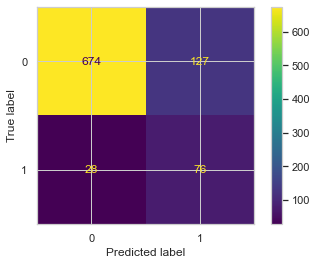

In [272]:
# Accuracy
prediction = model_logit.predict(X_test)
prediction_train = model_logit.predict(X_train)

# Recall
prediction_recall = model_logit_recall.predict(X_test)
prediction_recall_train = model_logit_recall.predict(X_train)

print(metrics.classification_report(y_test, prediction))
print("Logistic Regression Accuracy (Test): ", metrics.accuracy_score(y_test, prediction))
print("Logistic Regression Accuracy (Train): ", metrics.accuracy_score(y_train, prediction_train))

print("Logistic Regression Recall (Test): ", metrics.recall_score(y_test, prediction_recall))
print("Logistic Regression Recall (Train): ", metrics.recall_score(y_train, prediction_recall_train))

print(metrics.confusion_matrix(y_test, prediction))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, prediction)
pyplot.show()

# Random Forest Model Implementation

The Random Forest Classifier is a decision tree-based classification algorithm that uses randomness in generating individual tree to promote uncorrelated forests, which then uses the forest’s predictive powers to make accurate decisions. (Niklas, 2021)

## Hyperparameter Optimization (Model Tuning)

In [273]:
parameters_rforest = [
    {
        # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure 
        # or until all leaves contain less than min_samples_split samples.
        # Note: Max depth may cause overfitting (higher value) or underfitting (lower value).
        'classifier__max_depth': numpy.arange(10, 100, 10).tolist() + [None],

        # The minimum number of samples required to split an internal node.
        'classifier__min_samples_split': [2],

        # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered 
        # if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
        # This may have the effect of smoothing the model, especially in regression.
        'classifier__min_samples_leaf': [1, 2],

        # The number of trees in the forest.
        'classifier__n_estimators': [100] + numpy.arange(200, 2000, 200).tolist(),

        # The number of features to consider when looking for the best split
        # auto: max_features=sqrt(n_features)
        'classifier__max_features': ['auto', 'log2'],

        # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
        'classifier__bootstrap': [True, False],

        # The function to measure the quality of a split. 
        # Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
        'classifier__criterion': ['gini', 'entropy']
    }
]

Note: Depending on the number of trees (n_estimators), hyperparameter model tuning can take a long time due to the model's slow predictions times.

### Accuracy

In [274]:
classifier_rforest = RandomizedSearchCV(estimator=pipeline_rforest, param_distributions=parameters_rforest, 
                                        scoring='accuracy', cv = stratified_kfold, n_iter=iter_num)
model_rforest = classifier_rforest.fit(X_train, y_train.values.ravel())

In [275]:
print(f'Random Forest optimal hyperparameters for accuracy: {model_rforest.best_params_}')

Random Forest optimal hyperparameters for accuracy: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 50, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}


### Recall

In [276]:
classifier_rforest_recall = RandomizedSearchCV(estimator=pipeline_rforest, param_distributions=parameters_rforest, 
                                               scoring='recall', cv = stratified_kfold, n_iter=iter_num)
model_rforest_recall = classifier_rforest_recall.fit(X_train, y_train.values.ravel())

In [277]:
print(f'Random Forest optimal hyperparameters for recall: {model_rforest_recall.best_params_}')

Random Forest optimal hyperparameters for recall: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}


## Evaluation

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       801
           1       0.37      0.54      0.44       104

    accuracy                           0.84       905
   macro avg       0.65      0.71      0.67       905
weighted avg       0.87      0.84      0.85       905

Random Forest Classifier Accuracy (Test):  0.8419889502762431
Random Forest Classifier Accuracy (Train):  0.9546460176991151
Random Forest Classifier Recall (Test):  0.6442307692307693
Random Forest Classifier Recall (Train):  0.8848920863309353
[[706  95]
 [ 48  56]]


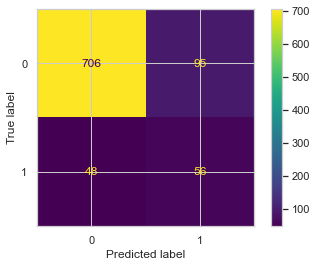

In [278]:
# Accuracy
prediction = model_rforest.predict(X_test)
prediction_train = model_rforest.predict(X_train)

# Recall
prediction_recall = model_rforest_recall.predict(X_test)
prediction_recall_train = model_rforest_recall.predict(X_train)

print(metrics.classification_report(y_test, prediction))
print("Random Forest Classifier Accuracy (Test): ", metrics.accuracy_score(y_test, prediction))
print("Random Forest Classifier Accuracy (Train): ", metrics.accuracy_score(y_train, prediction_train))

print("Random Forest Classifier Recall (Test): ", metrics.recall_score(y_test, prediction_recall))
print("Random Forest Classifier Recall (Train): ", metrics.recall_score(y_train, prediction_recall_train))

print(metrics.confusion_matrix(y_test, prediction))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, prediction)
pyplot.show()

# Models Evaluation

## Cross-Validation with Stratified K-Fold
Cross-validation will be used once more to estimate the model stability and performance of both the Logistic Regression and Random Forest.

In [279]:
def get_model_name(model):
    # get the imblearn pipeline used as estimator for RandomizedSearchCV 
    pipeline_ = model.best_estimator_  
    # get the classifier from the pipeline
    classifier_ = pipeline_.get_params()['classifier']
    # return the classifier's class name
    return classifier_.__class__.__name__

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

# custom scorer to save each fold's classification report to calculate the mean for all of them
def get_model_mean_report(model):
    def _clf_report_scorer(y_true, y_pred):
        true_c.extend(y_true)
        pred_c.extend(y_pred)
        return metrics.accuracy_score(y_true, y_pred)

    print(get_model_name(model))
    true_c, pred_c = [], []
    cross_val_score(estimator=model, X=X_train, y=y_train.values.ravel(), cv=stratified_kfold, 
                    scoring=metrics.make_scorer(_clf_report_scorer))
    print(f'\n{get_model_name(model)} cross-validation classification report with mean values: ')
    print(metrics.classification_report(true_c, pred_c))

In [280]:
get_model_mean_report(model_logit)

LogisticRegression

LogisticRegression cross-validation classification report with mean values: 
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      3199
           1       0.39      0.76      0.52       417

    accuracy                           0.84      3616
   macro avg       0.68      0.80      0.71      3616
weighted avg       0.90      0.84      0.86      3616



In [281]:
get_model_mean_report(model_rforest)

RandomForestClassifier

RandomForestClassifier cross-validation classification report with mean values: 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3199
           1       0.39      0.60      0.48       417

    accuracy                           0.85      3616
   macro avg       0.67      0.74      0.69      3616
weighted avg       0.88      0.85      0.86      3616



## ROC Curve
The ROC (receiver operating characteristic) curve plot illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied ("Receiver operating characteristic", 2021, para. 1), and will be used to compare the two models by evaluating their performance at all classification thresholds.

In [282]:
roc_table = pandas.DataFrame()

# get ROC-related metrics, including brier score, for both models
for model in [model_logit, model_rforest]:
    prediction_probability_estimates = model.predict_proba(X_test)
    auroc_score = metrics.roc_auc_score(y_test, prediction_probability_estimates[:, 1])
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, prediction_probability_estimates[:, 1])
    roc_data = {
        'model': get_model_name(model), 
        'false_positive_rate': false_positive_rate,
        'true_positive_rate': true_positive_rate,
        'auroc_score': auroc_score,
        'pr_auc_score': metrics.average_precision_score(y_test.values.ravel(), prediction_probability_estimates[:, 1]),
        'brier_score': metrics.brier_score_loss(y_test.values.ravel(), prediction_probability_estimates[:, 1])
    }
    roc_table = roc_table.append(roc_data, ignore_index=True)

roc_table.set_index('model', inplace=True)

roc_table

,auroc_score,brier_score,false_positive_rate,pr_auc_score,true_positive_rate
model,,,,,
LogisticRegression,0.870582,0.129280,"[0.0, 0.0, 0.0, 0.0012484394506866417, 0.00124...",0.524666,"[0.0, 0.009615384615384616, 0.0288461538461538..."
RandomForestClassifier,0.848309,0.108868,"[0.0, 0.0, 0.0, 0.0012484394506866417, 0.00124...",0.412652,"[0.0, 0.009615384615384616, 0.0288461538461538..."


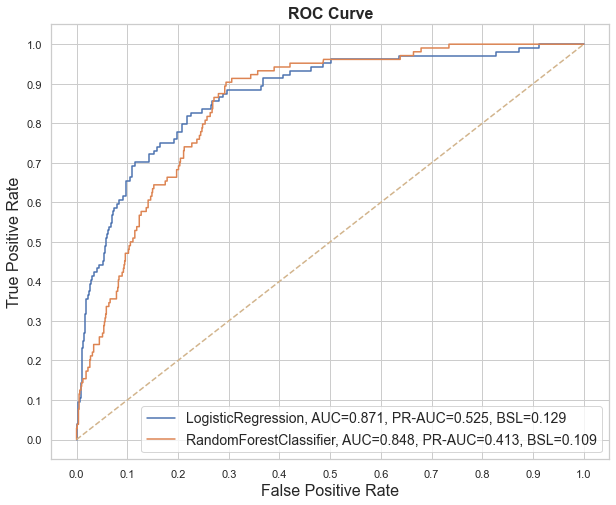

In [283]:
pyplot.figure(figsize=(10, 8))

# plot the ROC curve and display the scores in the label next to the model name
for model in roc_table.index:
    pyplot.plot(roc_table.loc[model]['false_positive_rate'], 
                roc_table.loc[model]['true_positive_rate'], 
                label="{}, AUC={:.3f}, PR-AUC={:.3f}, BSL={:.3f}".format(
                    model, roc_table.loc[model]['auroc_score'], roc_table.loc[model]['pr_auc_score'], roc_table.loc[model]['brier_score']))


# Adjust size and legend position so it's not covering anything and the scores are visible
pyplot.title('ROC Curve', fontweight='bold', fontsize=16)
pyplot.legend(loc='lower right', prop={'size':14})
pyplot.xlabel("False Positive Rate", fontsize=16)
pyplot.ylabel("True Positive Rate", fontsize=16)

pyplot.plot([0,1], [0,1], color='tan', linestyle='--')
pyplot.xticks(numpy.arange(0.0, 1.1, step=0.1))
pyplot.yticks(numpy.arange(0.0, 1.1, step=0.1))

pyplot.show()

# External Resources Used

* http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
* https://towardsdatascience.com/how-to-build-a-machine-learning-model-439ab8fb3fb1
* https://towardsdatascience.com/how-to-build-your-first-machine-learning-model-in-python-e70fd1907cdd
* https://towardsdatascience.com/why-linear-regression-is-not-suitable-for-binary-classification-c64457be8e28
* https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
* https://builtin.com/data-science/random-forest-algorithm
* https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148
* https://towardsdatascience.com/3-easy-ways-to-crosstab-in-pandas-4123383bfbf2
* https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7
* https://machinelearningmastery.com/what-is-imbalanced-classification/
* https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
* https://en.wikipedia.org/wiki/Accuracy_paradox
* https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d
* https://www.analyticsvidhya.com/blog/2020/10/how-to-choose-evaluation-metrics-for-classification-model/
* https://arxiv.org/pdf/1106.1813.pdf (SMOTE)
* https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote
* https://www.simplypsychology.org/p-value.html
* https://statisticsbyjim.com/
* https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
* https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
* https://stackoverflow.com/questions/50993867/increasing-n-jobs-has-no-effect-on-gridsearchcv

# Bilbiography

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

'Receiver operating characteristic', 2021, Wikipedia. Available at: https://en.wikipedia.org/wiki/Receiver_operating_characteristic (Accessed: 10 Nov 2021)